In [1]:
import numpy as np
import os
import glob

from random import *
from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, RMSprop

In [3]:
d = {}
from subprocess import check_output
with open('../input/iam-dataset/forms_for_parsing.txt') as f:
    for line in f:
        key = line.split(' ')[0]
        writer = line.split(' ')[1]
        d[key] = writer
print(len(d.keys()))

1539


In [4]:
tmp = []
target_list = []

path_to_files = os.path.join('../input/iam-dataset/data_subset/data_subset', '*')
for filename in sorted(glob.glob(path_to_files)):
    tmp.append(filename)
    image_name = filename.split('/')[-1]
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    form = parts[0] + '-' + parts[1]
    for key in d:
        if key == form:
            target_list.append(str(d[form]))

img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)
print(img_files.shape)
print(img_targets.shape)

(4899,)
(4899,)


# # **Visualization Of Images**


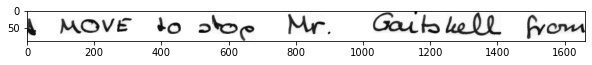

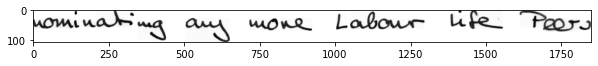

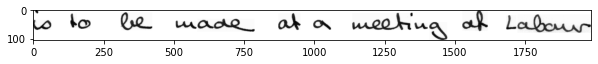

In [5]:
for filename in img_files[:3]:
    img=mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap ='gray')

In [6]:
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)

print(img_files[:5], img_targets[:5], encoded_Y[:5])

['../input/iam-dataset/data_subset/data_subset/a01-000u-s00-00.png'
 '../input/iam-dataset/data_subset/data_subset/a01-000u-s00-01.png'
 '../input/iam-dataset/data_subset/data_subset/a01-000u-s00-02.png'
 '../input/iam-dataset/data_subset/data_subset/a01-000u-s00-03.png'
 '../input/iam-dataset/data_subset/data_subset/a01-000u-s01-00.png'] ['000' '000' '000' '000' '000'] [0 0 0 0 0]


In [7]:
train_files, rem_files, train_targets, rem_targets = train_test_split(
        img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)

validation_files, test_files, validation_targets, test_targets = train_test_split(
        rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

(3233,) (833,) (833,)
(3233,) (833,) (833,)


# INPUT TO THE MODEL
As said before, we take patches of data, each of size 113x133. A generator function is implemented for that purpose.



In [8]:
batch_size = 16
num_classes = 50
def generate_data(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: 
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]
            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]
                height_fac = 113 / cur_height
                new_width = int(cur_width * height_fac)
                size = new_width, 113
                imresize = im.resize((size), Image.ANTIALIAS)  
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                avail_x_points = list(range(0, now_width - 113 ))
                pick_num = int(len(avail_x_points)*factor)
                random_startx = sample(avail_x_points,  pick_num)
                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)
            X_train = np.array(images)
            y_train = np.array(targets)
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
            X_train = X_train.astype('float32')
            X_train /= 255
            y_train = to_categorical(y_train, num_classes)
            yield shuffle(X_train, y_train)

For training and testing, generator function is called with the intent of making train and test generator data.



In [9]:
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)

A Keras Model is built. Summary of the model is printed below.



In [11]:
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize(image,[56,56])

row, col, ch = 113, 113, 1
model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))
model.add(Lambda(resize_image)) 
model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))
model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))
model.add(Convolution2D(filters= 128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3'))  
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, name='dense1')) 
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256, name='dense2'))  
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))  
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 115, 115, 1)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 56, 56, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)       

# Training the model
Let's take 8 epochs. And the following specifications.

In [34]:
# nb_epoch = 8

# samples_per_epoch = 3268
# nb_val_samples = 842


# #save every model using Keras checkpoint
# from keras.callbacks import ModelCheckpoint
# filepath="checkpoint2/check-{epoch:02d}-{val_loss:.4f}.hdf5"
# checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
# callbacks_list = [checkpoint]

# #Model fit generator
# history_object = model.fit_generator(train_generator, samples_per_epoch= samples_per_epoch,
#                                      validation_data=validation_generator,
#                                      nb_val_samples=nb_val_samples, nb_epoch=nb_epoch, verbose=1, callbacks=callbacks_list)


# Performance Metrics
Let's now test our model for calculating accuracy

In [35]:
# model.load_weights('low_loss.hdf5')
# scores = model.evaluate_generator(test_generator,842) 
# print("Accuracy = ", scores[1])

Load in testdata

In [36]:
# images = []
# for filename in test_files[:50]:
#     im = Image.open(filename)
#     cur_width = im.size[0]
#     cur_height = im.size[1]

#     # print(cur_width, cur_height)
#     height_fac = 113 / cur_height

#     new_width = int(cur_width * height_fac)
#     size = new_width, 113

#     imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
#     now_width = imresize.size[0]
#     now_height = imresize.size[1]
#     # Generate crops of size 113x113 from this resized image and keep random 10% of crops

#     avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

#     # Pick random x%
#     factor = 0.1
#     pick_num = int(len(avail_x_points)*factor)
    
#     random_startx = sample(avail_x_points,  pick_num)

#     for start in random_startx:
#         imcrop = imresize.crop((start, 0, start+113, 113))
#         images.append(np.asarray(imcrop))
        
#     X_test = np.array(images)
    
#     X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
#     #convert to float and normalize
#     X_test = X_test.astype('float32')
#     X_test /= 255
#     shuffle(X_test)
# print(X_test.shape)


# PREDICTIONS

In [37]:
# predictions = model.predict(X_test, verbose =1)

# print(predictions.shape)
# predicted_writer = []
# for pred in predictions:
#     predicted_writer.append(np.argmax(pred))
# print(len(predicted_writer))

# INSIGHTS

In [ ]:
# writer_number = 18
# total_images =10
# counter = 0
# for i in range(len(predicted_writer)//10):
#     if predicted_writer[i] == writer_number:
#         image = X_test[i].squeeze()
#         plt.figure(figsize=(2,2))
#         plt.imshow(image, cmap ='gray')